# QB Positioning Analysis

In [6]:
import os
import re
import sys
import tqdm
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import random
import seaborn as sns

# Libraries required for plotting field
import matplotlib.patches as patches
from matplotlib.patches import Arc
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import animation
from IPython.display import HTML
from IPython import display


# Custom libraries
sys.path.append('../')
from src.utils.viz_functions import visualize_play
from src.utils.play_preprocessing import preprocessPlay_refQB_NFrames, preprocessPlay_refQB, preprocessPlay_refLineScrimmageInit, extractPlay
from src.utils.player_influence import extract_play_players_influence, gaussian_player_influence_score
from src.utils.field_price_functions import calculate_field_price, gaussian_field_price
from src.utils.calculate_score import calculate_score
from src.utils.full_pipeline import run_full_pipeline, run_short_pipeline

In [2]:
# Define input parameters
input_path = '../input'
preprocessing_path = '../processing'

config = {
    # Preprocessing Play parameters
    'preprocess_funct': preprocessPlay_refLineScrimmageInit,
    'hold_QB_ref': 20,
    'post_snap_time': 8,

    # Pocket parameters
    'pocket_len': 10.0,
    'pocket_res': 0.1,

    # Field Price parameters
    'pocket_linear_max_value': 1.0,
    'pocket_gaus_mu': 0.0,
    'pocket_gaus_sigma': 5.0,
    'field_price_funct': gaussian_field_price,

    # Player Influence parameters
    'gaus_mu': 0.0,
    'gaus_sigma': 2.0,
    'player_infl_funct': gaussian_player_influence_score
}

# 1. Single Play Analysis

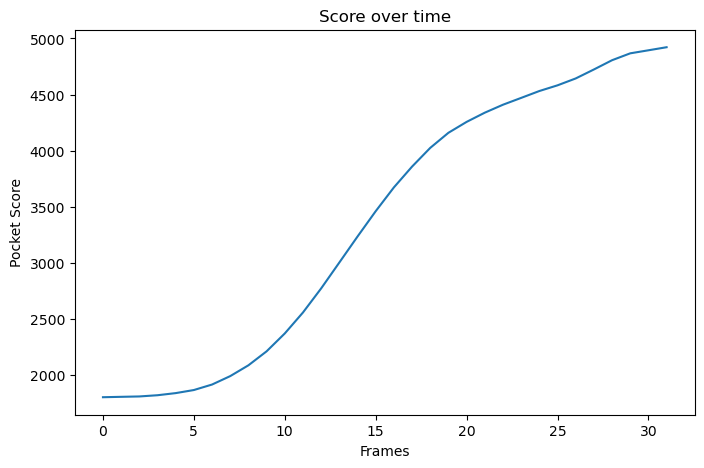

In [3]:
week1_data = pd.read_csv(os.path.join(input_path, 'week1.csv'))

# Define Game & Play ID
gameId = "2021090900"
playId = "3933"

visualize_play(week1_data, gameId, playId, config)

In [9]:
# Preprocess the play
team1, team2, ball = extractPlay(week_data=week1_data, gameId=gameId, playId=playId, input_path=input_path)
team1, team2, ball = preprocessPlay_refLineScrimmageInit(team1, team2, ball)

# Extract the QB of this specific play
# - Obtain list of players
list_players = team1.nflId.unique().tolist()
# - Extract QB ID
qb_id = pd.read_csv(os.path.join(input_path, 'players.csv')).query("nflId == @list_players & officialPosition == 'QB'")
# - Run certain checks - QB available and only one QB
# - If an error is raised, we look for the QB
if (qb_id.empty) | (len(qb_id) > 1):

    # - Determine the moment the ball was snapped
    frame_snap = ball.loc[ball.event == 'ball_snap', 'frameId'].values[0] + config['post_snap_time']

    # - Extract information regarding relative position of players from ball
    ball_pos = ball.loc[ball.frameId == frame_snap, ['x', 'y', 'event']]
    dist_players = team1.loc[team1.frameId == frame_snap, ['nflId', 'x', 'y']]

    # - Determine which player has the ball in frame frame_qb
    dist_players['abs_distance'] = dist_players.apply(lambda player: math.sqrt((player.x - ball_pos.x)**2 + (player.y - ball_pos.y)**2), axis=1)
    qb_id = dist_players.loc[dist_players.abs_distance == min(dist_players.abs_distance), 'nflId'].values[0]

else:
    # If everything is ok, move on
    qb_id = qb_id.nflId.values.flatten()[0]

qb_data = team1.loc[team1.nflId == qb_id, :]
qb_data


frameId team    nflId playDirection     x     y     s     a   dis  \
76360        1   TB  25511.0         right  3.49  0.00  0.00  0.00  0.00   
76361        2   TB  25511.0         right  3.49  0.01  0.00  0.00  0.00   
76362        3   TB  25511.0         right  3.49  0.01  0.00  0.00  0.00   
76363        4   TB  25511.0         right  3.48  0.01  0.00  0.00  0.01   
76364        5   TB  25511.0         right  3.46  0.01  0.00  0.00  0.02   
76365        6   TB  25511.0         right  3.45  0.01  0.00  0.00  0.01   
76366        7   TB  25511.0         right  3.44  0.02  0.00  0.00  0.01   
76367        8   TB  25511.0         right  3.42  0.02  0.02  0.75  0.02   
76368        9   TB  25511.0         right  3.40  0.02  0.38  4.36  0.02   
76369       10   TB  25511.0         right  3.32  0.03  1.02  5.76  0.08   
76370       11   TB  25511.0         right  3.16  0.05  1.83  6.49  0.16   
76371       12   TB  25511.0         right  2.92  0.07  2.57  6.30  0.23   
76372       13   TB  25511.0         right  2.61  0.09  3.31  5.88  0.31   
76373       14   TB  25511.0         right  2.25  0.11  3.84  4.86  0.36   
76374       15   TB  25511.0         right  1.85  0.13  4.25  3.74  0.40   
76375       16   TB  25511.0         right  1.43  0.13  4.48  2.53  0.42   
76376       17   TB  25511.0         right  0.98  0.16  4.63  1.47  0.45   
76377       18   TB  25511.0         right  0.52  0.17  4.69  0.57  0.46   
76378       19   TB  25511.0         right  0.06  0.18  4.66  0.48  0.46   
76379       20   TB  25511.0         right -0.39  0.18  4.43  1.42  0.44   
76380       21   TB  25511.0         right -0.81  0.18  4.11  2.21  0.42   
76381       22   TB  25511.0         right -1.19  0.19  3.77  2.71  0.39   
76382       23   TB  25511.0         right -1.53  0.20  3.35  3.14  0.34   
76383       24   TB  25511.0         right -1.82  0.20  2.82  3.56  0.28   
76384       25   TB  25511.0         right -2.08  0.21  2.41  3.73  0.26   
76385       26   TB  25511.0         right -2.29  0.22  1.99  3.60  0.21   
76386       27   TB  25511.0         right -2.47  0.22  1.63  3.36  0.18   
76387       28   TB  25511.0         right -2.62  0.22  1.38  2.81  0.16   
76388       29   TB  25511.0         right -2.75  0.21  1.19  2.20  0.13   
76389       30   TB  25511.0         right -2.87  0.22  1.10  1.49  0.12   
76390       31   TB  25511.0         right -2.97  0.23  0.94  1.22  0.10   
76391       32   TB  25511.0         right -3.07  0.24  0.97  0.69  0.10   

            o     dir                  event  
76360   79.88   31.79                   None  
76361   79.88   24.86                   None  
76362   79.88   14.97                   None  
76363   81.24  343.40                   None  
76364   81.24  308.97                   None  
76365   81.24  301.76              ball_snap  
76366   83.34  295.52                   None  
76367   86.22  279.85                   None  
76368   87.98  277.57                   None  
76369   91.67  276.82                   None  
76370   98.07  276.58                   None  
76371  101.66  275.37                   None  
76372  105.95  274.59                   None  
76373  112.86  274.05                   None  
76374  122.47  272.89                   None  
76375  135.00  271.75                   None  
76376  138.79  272.04                   None  
76377  136.10  271.73                   None  
76378  132.30  270.48                   None  
76379  126.05  270.18                   None  
76380  120.92  270.52                   None  
76381  113.61  270.26                   None  
76382  105.32  271.05                   None  
76383   93.93  271.41                   None  
76384   76.94  271.52                   None  
76385   61.78  272.11                   None  
76386   35.55  271.83  autoevent_passforward  
76387   13.69  268.98           pass_forward  
76388  356.00  268.67                   None  
76389  345.46  270.52                   None  
76390  340.33  274.80                   N

<AxesSubplot:xlabel='frameId', ylabel='s'>

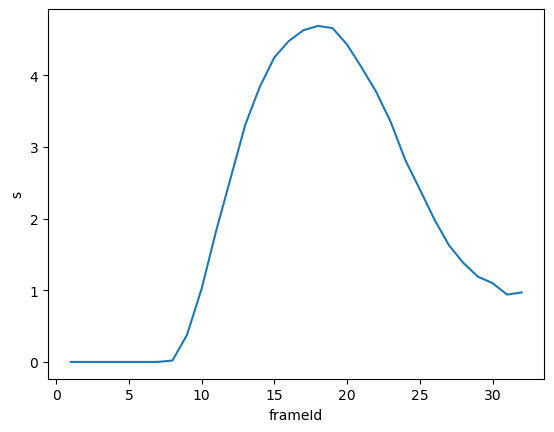

In [12]:
sns.lineplot(data=qb_data, x='frameId', y='s')

# 2. Game Analysis

Using the functions discovered before, let's look at an entire game

100%|██████████| 97/97 [00:11<00:00,  8.58it/s]


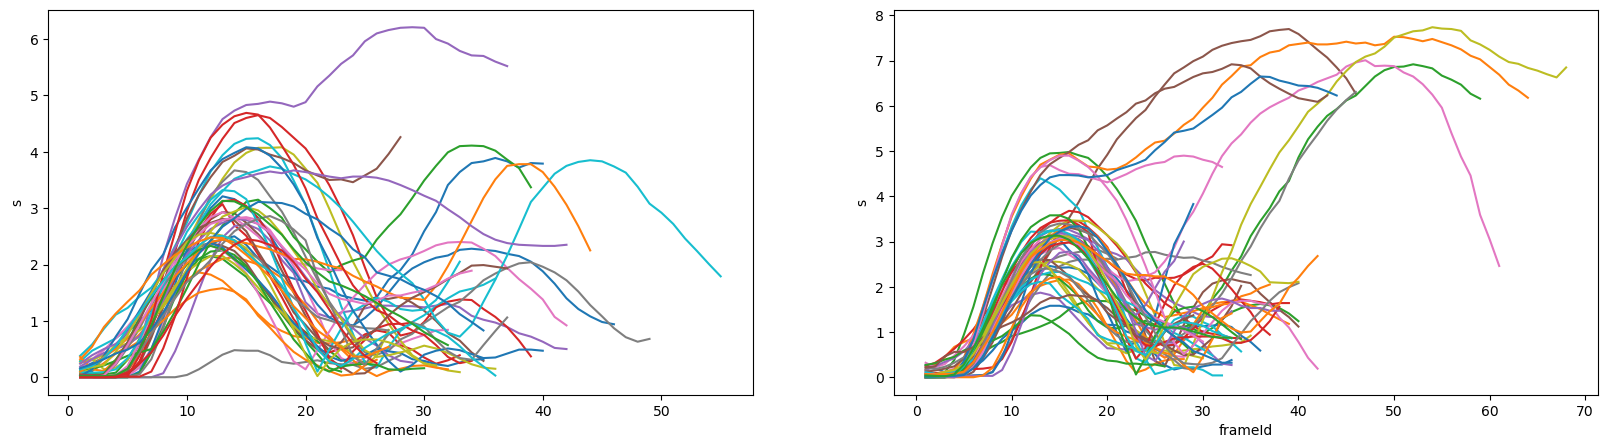

In [28]:
# Read week's data
week1_data = pd.read_csv(os.path.join(input_path, 'week1.csv'))

gameId = 2021090900

# Extract information about the associated games and plays
unique_plays = week1_data.loc[week1_data.gameId == gameId, 'playId'].drop_duplicates().values
unique_teams = week1_data.loc[week1_data.gameId == gameId, 'team'].drop_duplicates().values

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 5))

for playId in tqdm.tqdm(unique_plays):

    # Preprocess the play
    team1, team2, ball = extractPlay(week_data=week1_data, gameId=gameId, playId=playId, input_path=input_path)
    team1, team2, ball = preprocessPlay_refLineScrimmageInit(team1, team2, ball)

    # Extract the QB of this specific play
    # - Obtain list of players
    list_players = team1.nflId.unique().tolist()
    # - Extract QB ID
    qb_id = pd.read_csv(os.path.join(input_path, 'players.csv')).query("nflId == @list_players & officialPosition == 'QB'")
    # - Run certain checks - QB available and only one QB
    # - If an error is raised, we look for the QB
    if (qb_id.empty) | (len(qb_id) > 1):

        # - Determine the moment the ball was snapped
        frame_snap = ball.loc[ball.event == 'ball_snap', 'frameId'].values[0] + config['post_snap_time']

        # - Extract information regarding relative position of players from ball
        ball_pos = ball.loc[ball.frameId == frame_snap, ['x', 'y', 'event']]
        dist_players = team1.loc[team1.frameId == frame_snap, ['nflId', 'x', 'y']]

        # - Determine which player has the ball in frame frame_qb
        dist_players['abs_distance'] = dist_players.apply(lambda player: math.sqrt((player.x - ball_pos.x)**2 + (player.y - ball_pos.y)**2), axis=1)
        qb_id = dist_players.loc[dist_players.abs_distance == min(dist_players.abs_distance), 'nflId'].values[0]

    else:
        # If everything is ok, move on
        qb_id = qb_id.nflId.values.flatten()[0]

    # Obtain information for the QB
    qb_data = team1.loc[team1.nflId == qb_id, :]

    # Extract information regarding the ball snap to remove anything before that
    snap_frame = qb_data.loc[qb_data.event == "ball_snap", 'frameId']
    if snap_frame.empty:
        snap_frame = 0
    else:
        snap_frame = snap_frame.values[0] - 3

    # Remove anything before the snap
    qb_data = qb_data.loc[qb_data.frameId > snap_frame]
    qb_data['frameId'] =  qb_data['frameId'] - snap_frame

    if (qb_data.team.values[0] == unique_teams[0]):
        sns.lineplot(data=qb_data, x='frameId', y='s', ax=ax1)
    else:
        sns.lineplot(data=qb_data, x='frameId', y='s', ax=ax2)

fig.savefig(f"{preprocessing_path}/qb_positioning/{gameId}_QB_speed.png")


# 3. Full Week Analysis

 - Analyzing 2021090900


100%|██████████| 97/97 [00:07<00:00, 12.30it/s]


 - Analyzing 2021091200


100%|██████████| 73/73 [00:06<00:00, 12.01it/s]


 - Analyzing 2021091201


100%|██████████| 81/81 [00:06<00:00, 12.01it/s]


 - Analyzing 2021091202


100%|██████████| 72/72 [00:06<00:00, 10.87it/s]


 - Analyzing 2021091203


100%|██████████| 76/76 [00:06<00:00, 12.11it/s]


 - Analyzing 2021091204


100%|██████████| 89/89 [00:07<00:00, 12.13it/s]


 - Analyzing 2021091205


100%|██████████| 79/79 [00:06<00:00, 12.15it/s]


 - Analyzing 2021091206


100%|██████████| 64/64 [00:06<00:00, 10.64it/s]


 - Analyzing 2021091207


100%|██████████| 67/67 [00:05<00:00, 12.14it/s]


 - Analyzing 2021091208


100%|██████████| 71/71 [00:05<00:00, 12.30it/s]


 - Analyzing 2021091209


100%|██████████| 66/66 [00:05<00:00, 12.18it/s]


 - Analyzing 2021091210


100%|██████████| 60/60 [00:04<00:00, 12.02it/s]


 - Analyzing 2021091211


100%|██████████| 48/48 [00:04<00:00, 10.89it/s]


 - Analyzing 2021091212


100%|██████████| 76/76 [00:08<00:00,  9.14it/s]


 - Analyzing 2021091213


100%|██████████| 61/61 [00:05<00:00, 12.08it/s]


 - Analyzing 2021091300


100%|██████████| 95/95 [00:08<00:00, 11.36it/s]


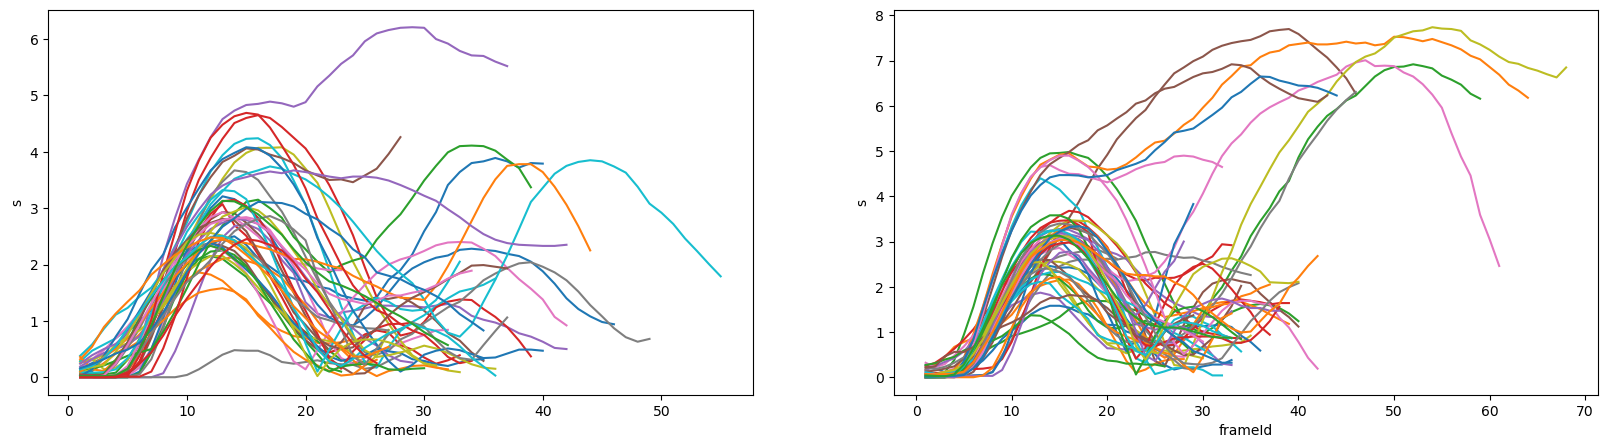

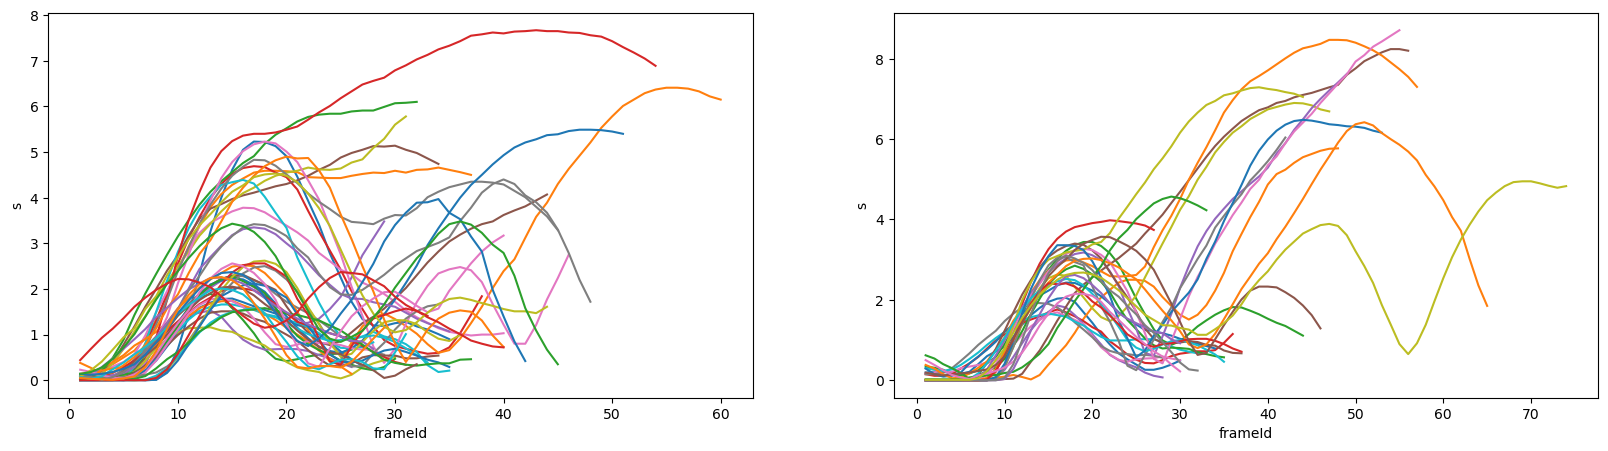

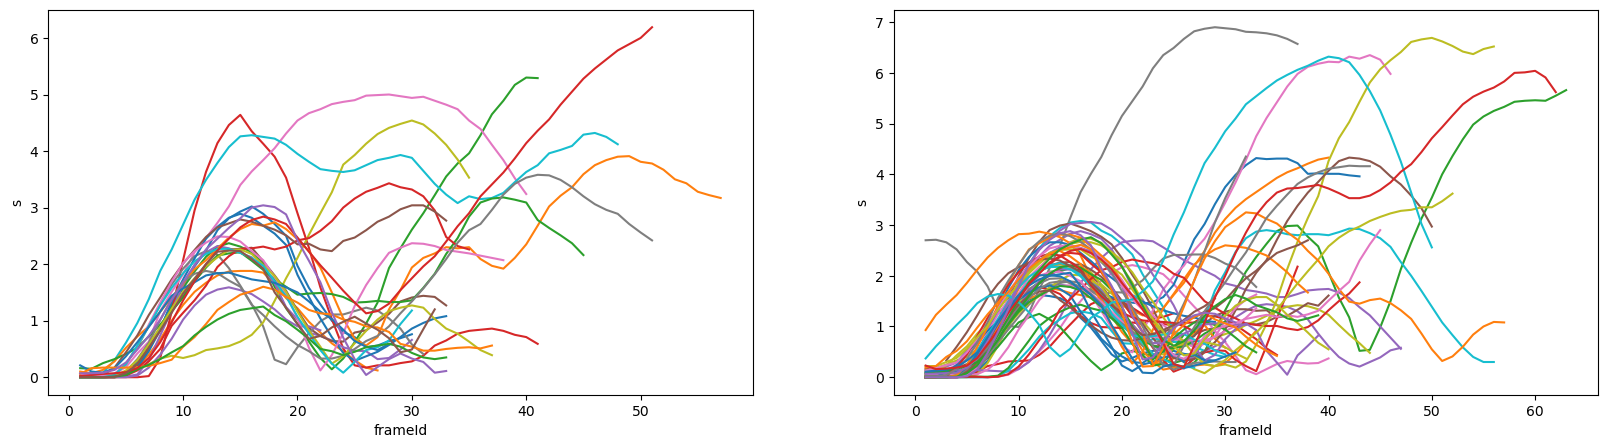

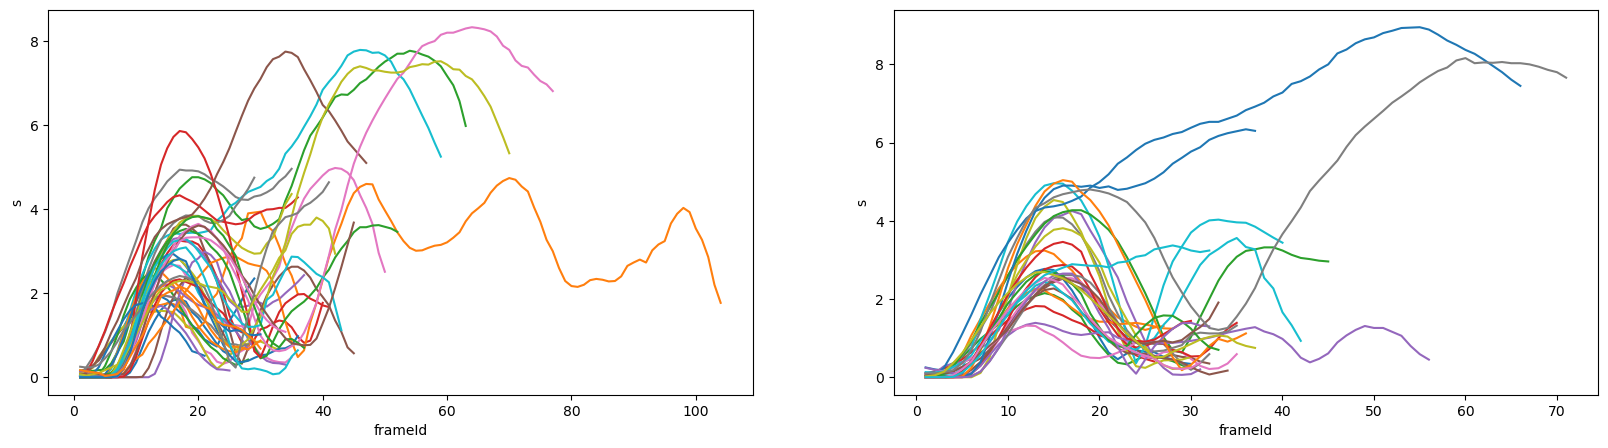

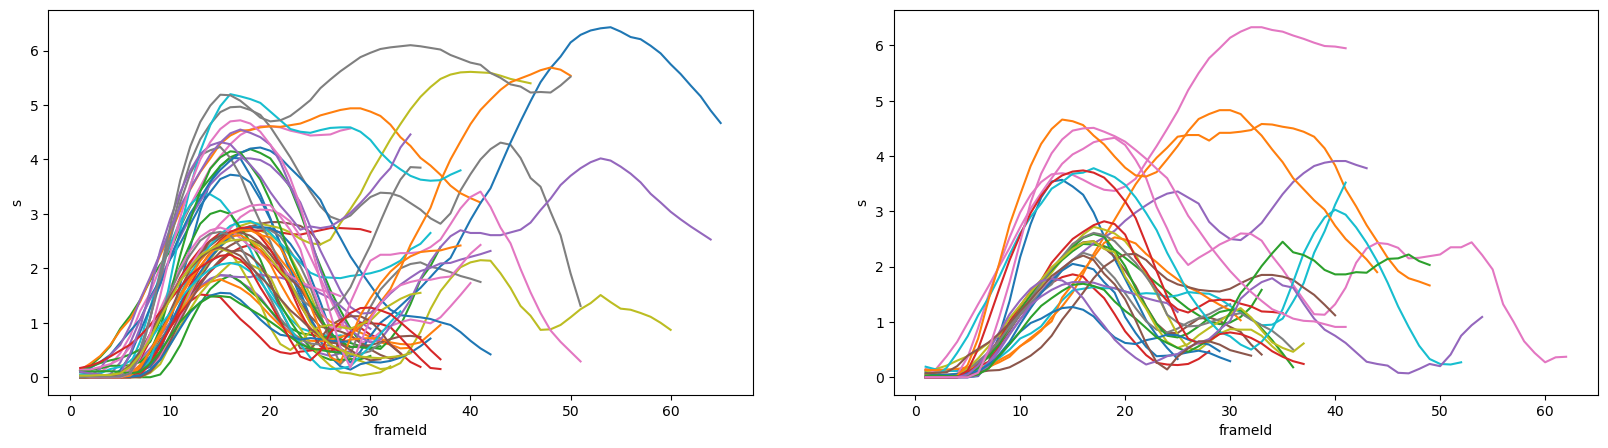

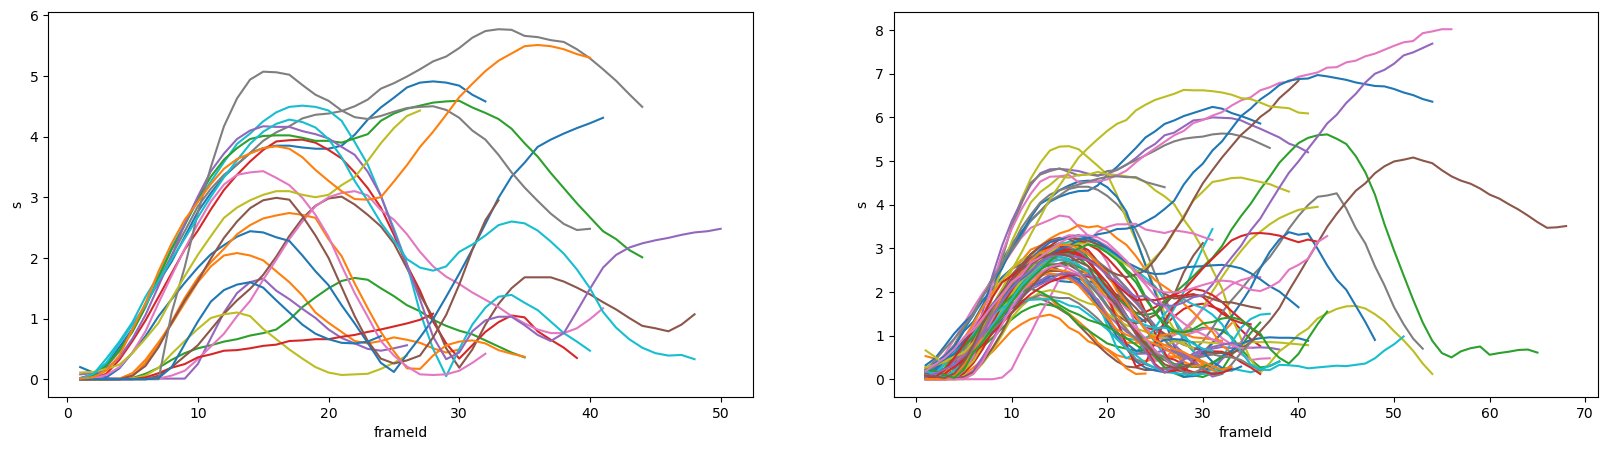

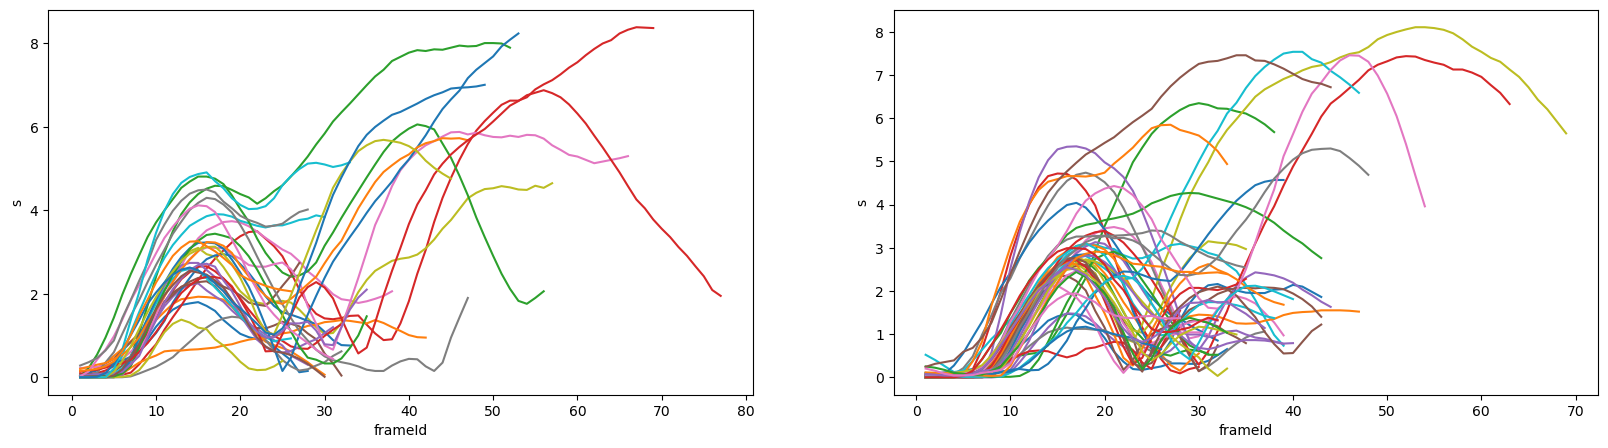

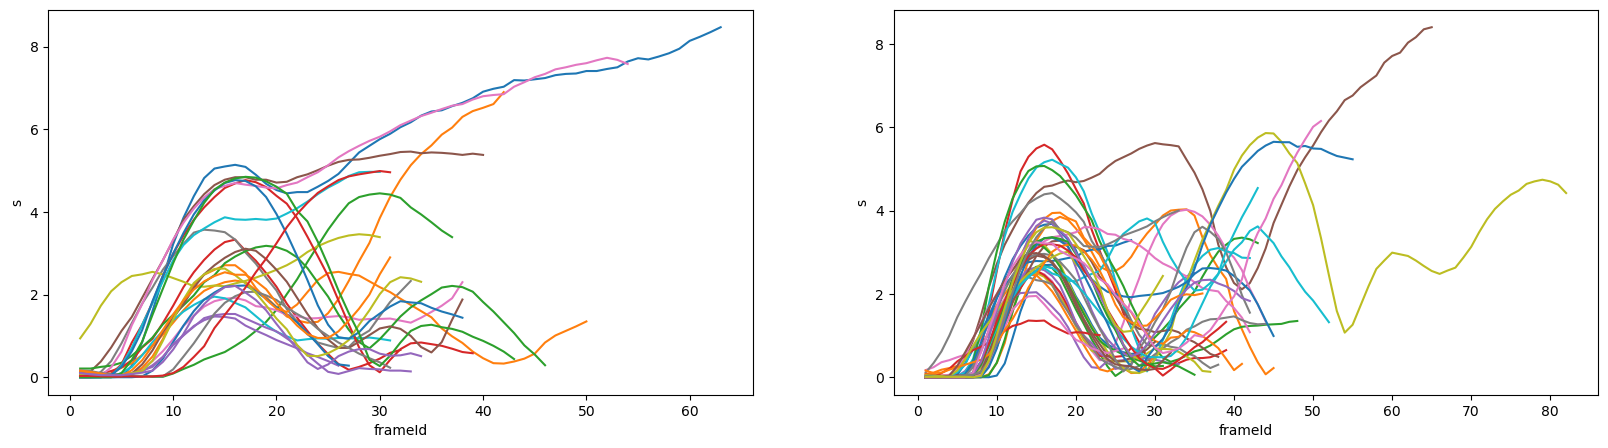

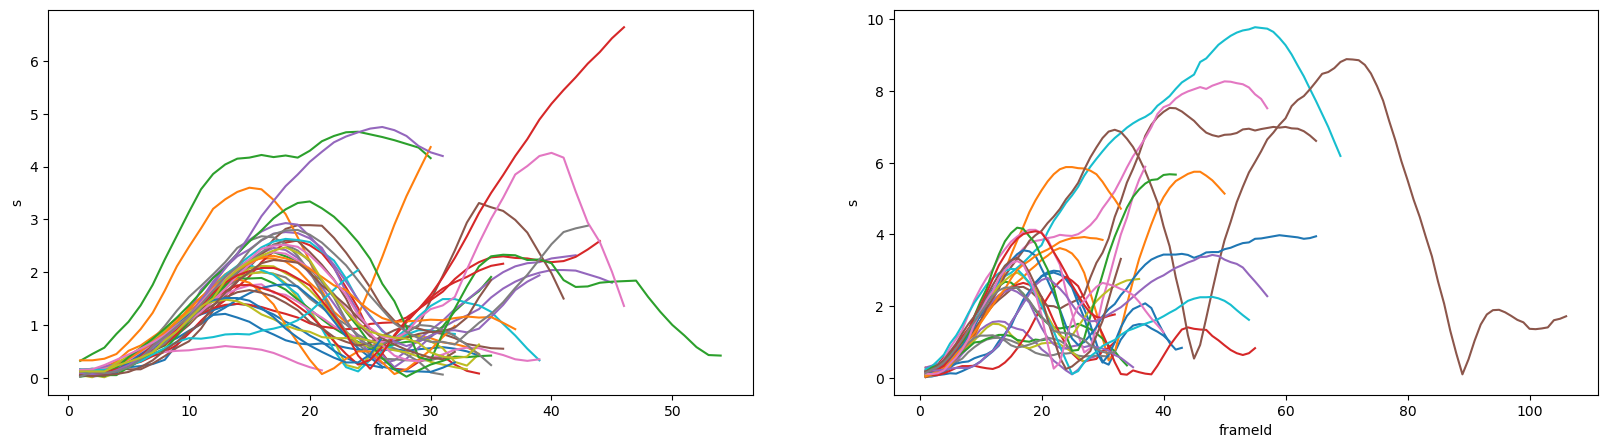

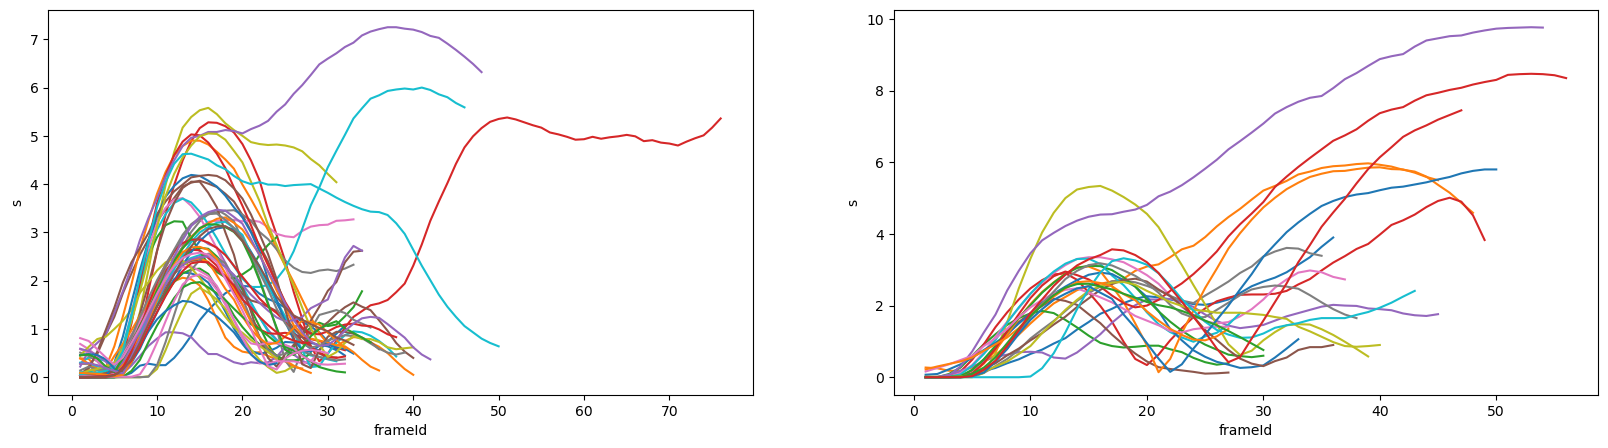

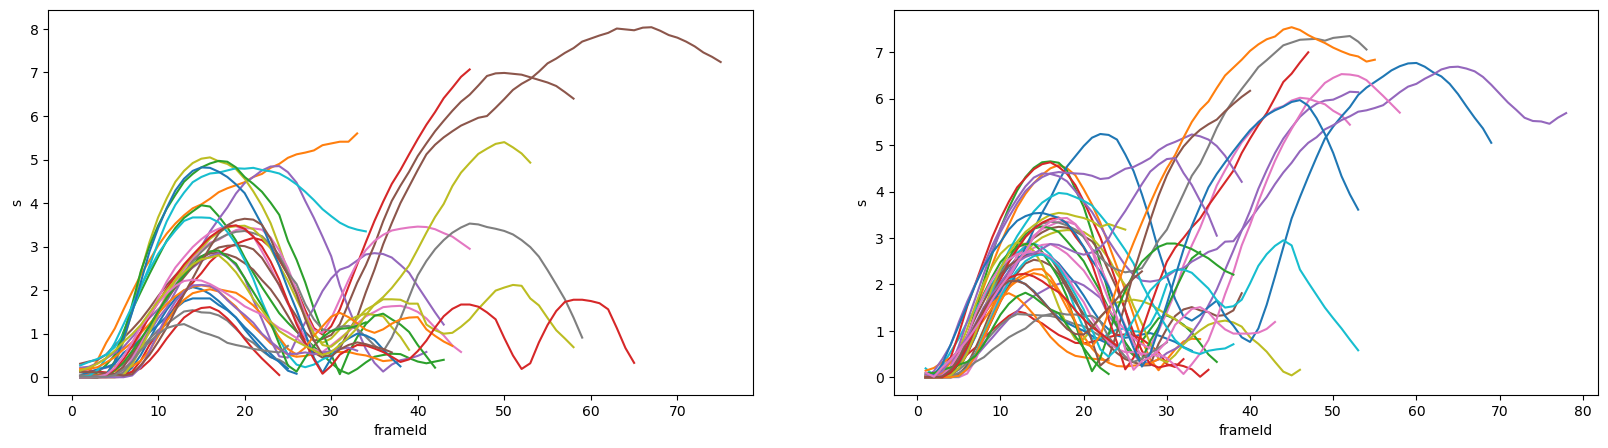

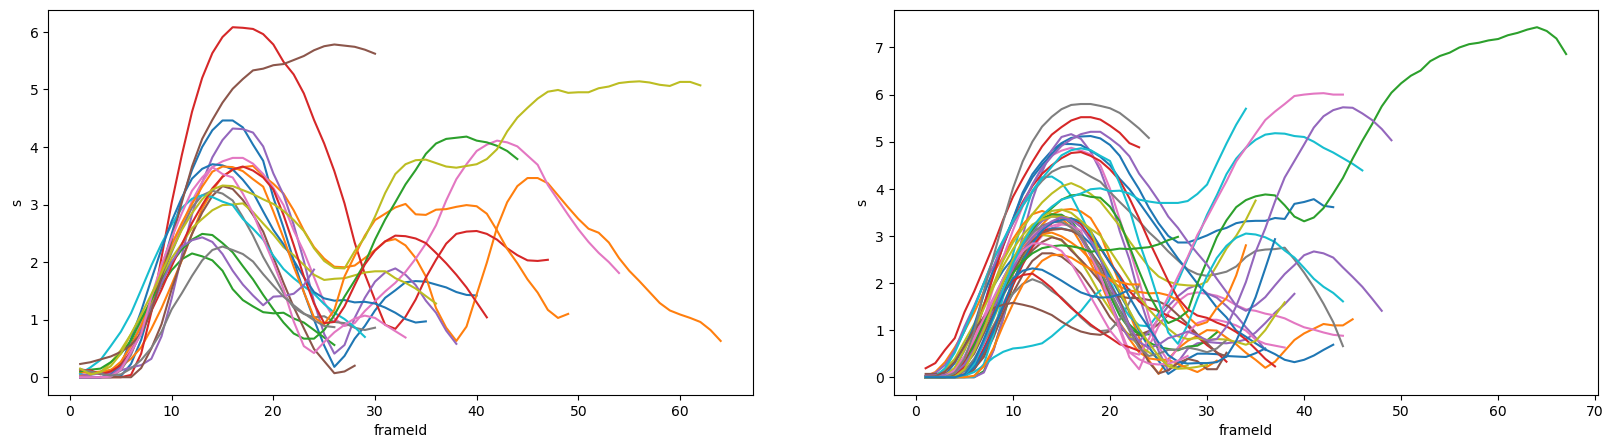

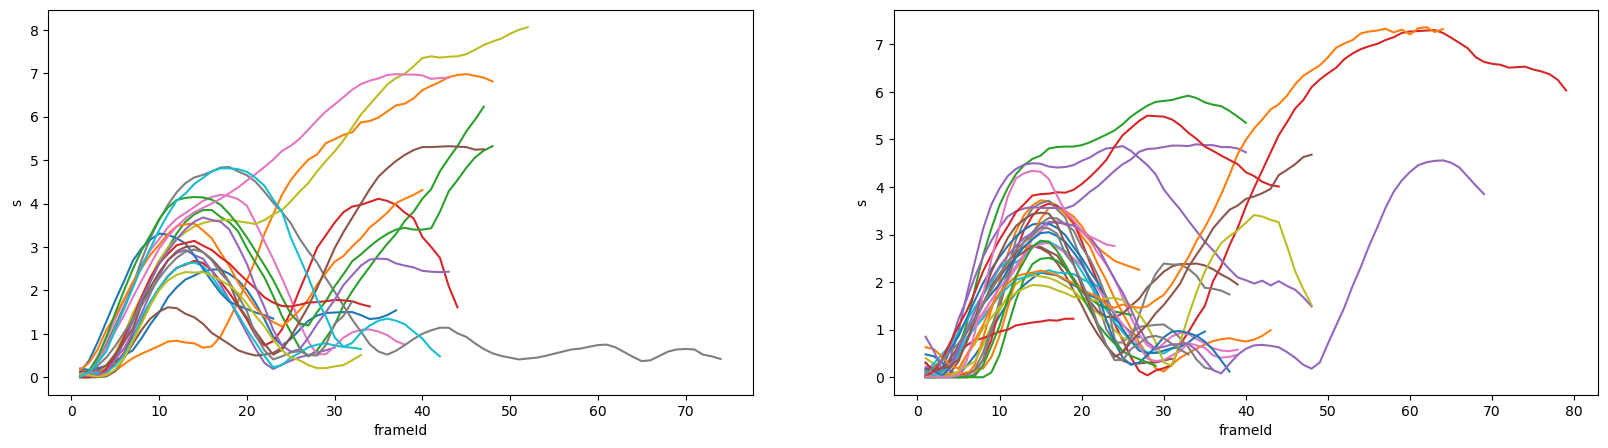

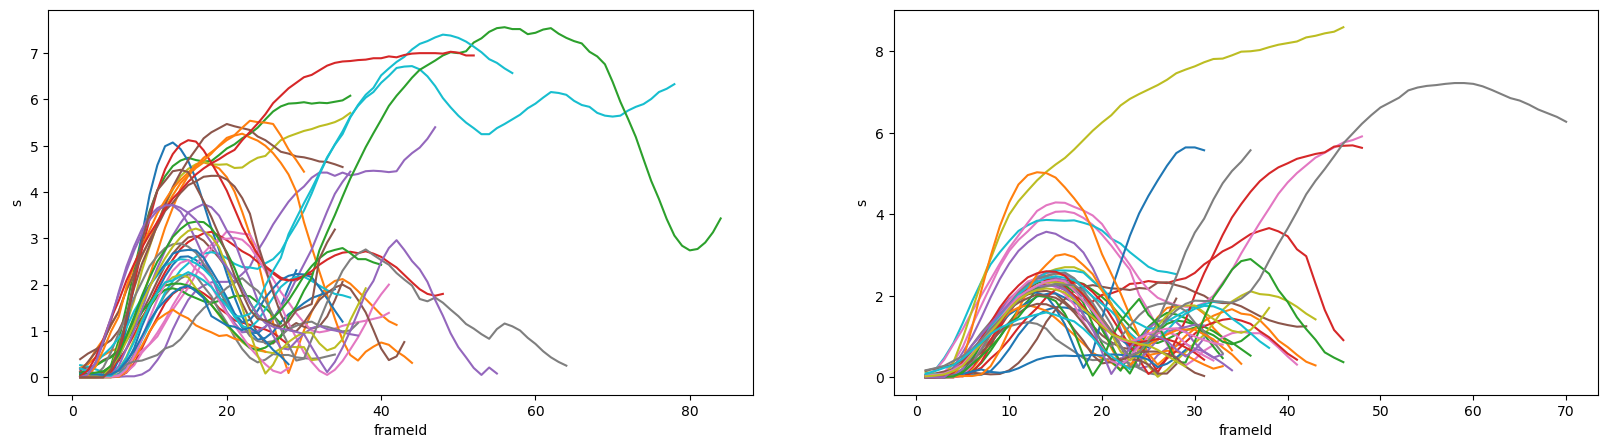

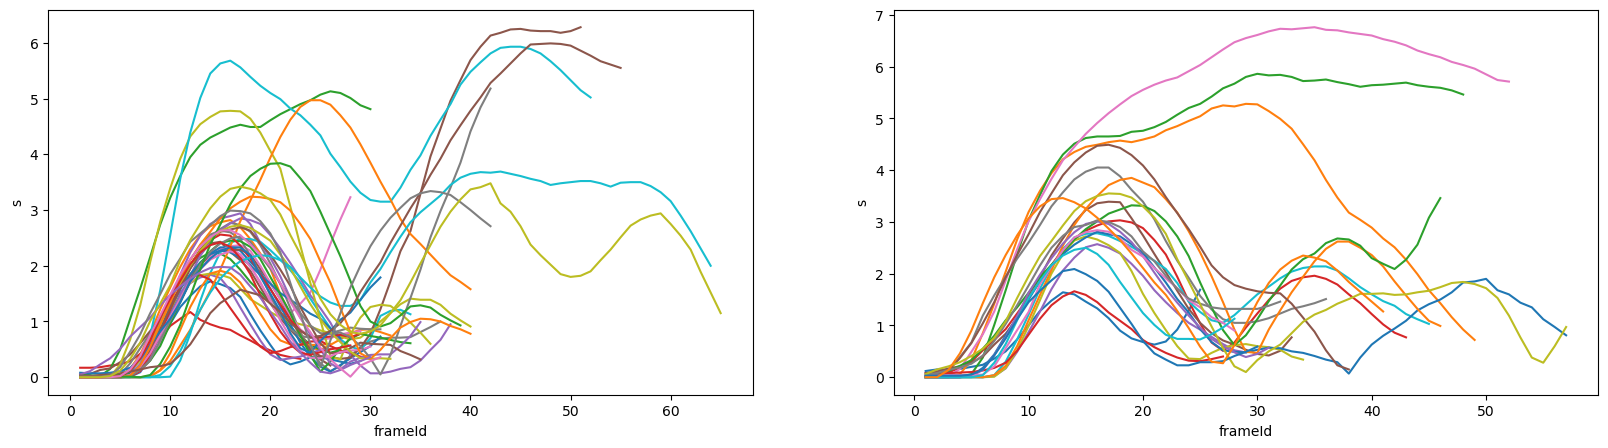

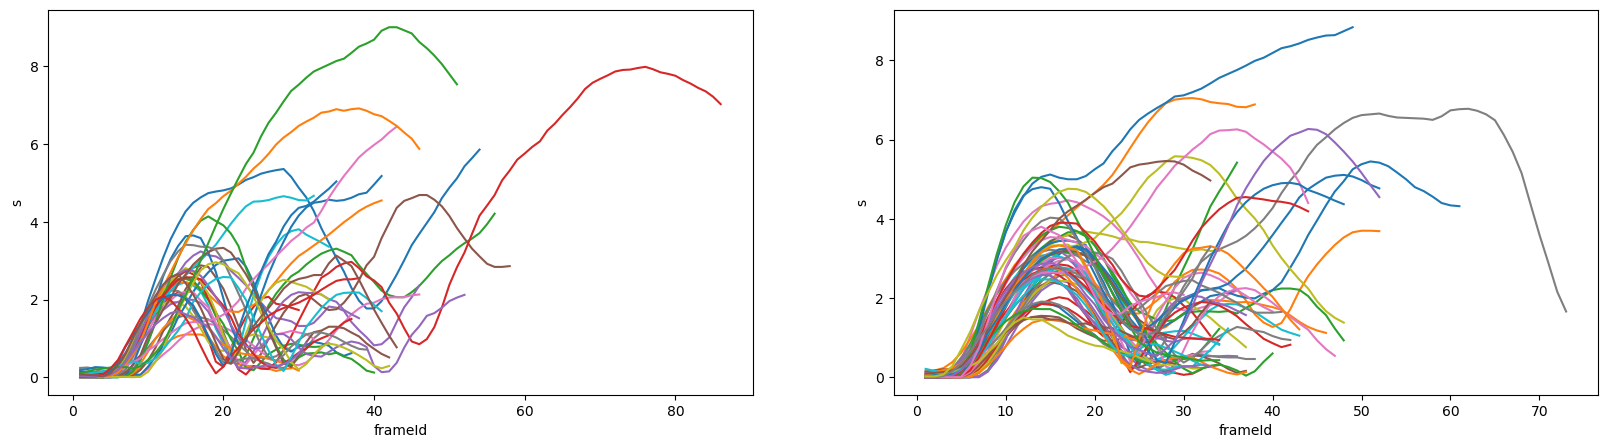

In [46]:
# Read week's data
week1_data = pd.read_csv(os.path.join(input_path, 'week1.csv'))

# Extract information about the associated games and plays
unique_games = week1_data[['gameId']].drop_duplicates().values.flatten()

for gameId in unique_games:

    print(f" - Analyzing {gameId}")
    unique_plays = week1_data.loc[week1_data.gameId == gameId, 'playId'].drop_duplicates().values
    unique_teams = week1_data.loc[week1_data.gameId == gameId, 'team'].drop_duplicates().values

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 5))

    for playId in tqdm.tqdm(unique_plays):

        # Preprocess the play
        team1, team2, ball = extractPlay(week_data=week1_data, gameId=gameId, playId=playId, input_path=input_path)
        team1, team2, ball = preprocessPlay_refLineScrimmageInit(team1, team2, ball)

        # Extract the QB of this specific play
        # - Obtain list of players
        list_players = team1.nflId.unique().tolist()
        # - Extract QB ID
        qb_id = pd.read_csv(os.path.join(input_path, 'players.csv')).query("nflId == @list_players & officialPosition == 'QB'")
        # - Run certain checks - QB available and only one QB
        # - If an error is raised, we look for the QB
        if (qb_id.empty) | (len(qb_id) > 1):

            # - Determine the moment the ball was snapped
            frame_snap = ball.loc[ball.event == 'ball_snap', 'frameId'].values[0] + config['post_snap_time']

            # - Extract information regarding relative position of players from ball
            ball_pos = ball.loc[ball.frameId == frame_snap, ['x', 'y', 'event']]
            dist_players = team1.loc[team1.frameId == frame_snap, ['nflId', 'x', 'y']]

            # - Determine which player has the ball in frame frame_qb
            dist_players['abs_distance'] = dist_players.apply(lambda player: math.sqrt((player.x - ball_pos.x)**2 + (player.y - ball_pos.y)**2), axis=1)
            qb_id = dist_players.loc[dist_players.abs_distance == min(dist_players.abs_distance), 'nflId'].values[0]

        else:
            # If everything is ok, move on
            qb_id = qb_id.nflId.values.flatten()[0]

        # Obtain information for the QB
        qb_data = team1.loc[team1.nflId == qb_id, :]

        # Extract information regarding the ball snap to remove anything before that
        snap_frame = qb_data.loc[qb_data.event == "ball_snap", 'frameId']
        if snap_frame.empty:
            snap_frame = 0
        else:
            snap_frame = snap_frame.values[0] - 3

        # Remove anything before the snap
        qb_data = qb_data.loc[qb_data.frameId > snap_frame]
        qb_data['frameId'] =  qb_data['frameId'] - snap_frame

        if (qb_data.team.values[0] == unique_teams[0]):
            sns.lineplot(data=qb_data, x='frameId', y='s', ax=ax1)
        else:
            sns.lineplot(data=qb_data, x='frameId', y='s', ax=ax2)

    fig.savefig(f"{preprocessing_path}/qb_positioning/{gameId}_QB_speed.png")

# 4. Full Season Analysis - THIS IS A LONG RUN

In [65]:
def process_qb_speed_for_game(week_data, gameId):
    
    print(f" - Analyzing {gameId}")
    unique_plays = week_data.loc[week_data.gameId == gameId, 'playId'].drop_duplicates().values
    unique_teams = week_data.loc[week_data.gameId == gameId, 'team'].drop_duplicates().values

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 5))

    for playId in tqdm.tqdm(unique_plays):

        # Preprocess the play
        team1, team2, ball = extractPlay(week_data=week_data, gameId=gameId, playId=playId, input_path=input_path)
        team1, team2, ball = preprocessPlay_refLineScrimmageInit(team1, team2, ball)

        # Extract the QB of this specific play
        # - Obtain list of players
        list_players = team1.nflId.unique().tolist()
        # - Extract QB ID
        qb_id = pd.read_csv(os.path.join(input_path, 'players.csv')).query("nflId == @list_players & officialPosition == 'QB'")
        # - Run certain checks - QB available and only one QB
        # - If an error is raised, we look for the QB
        if (qb_id.empty) | (len(qb_id) > 1):

            # - Determine the moment the ball was snapped
            frame_snap = ball.loc[ball.event == 'ball_snap', 'frameId'].values[0] + config['post_snap_time']

            # - Extract information regarding relative position of players from ball
            ball_pos = ball.loc[ball.frameId == frame_snap, ['x', 'y', 'event']]
            dist_players = team1.loc[team1.frameId == frame_snap, ['nflId', 'x', 'y']]

            # - Determine which player has the ball in frame frame_qb
            dist_players['abs_distance'] = dist_players.apply(lambda player: math.sqrt((player.x - ball_pos.x)**2 + (player.y - ball_pos.y)**2), axis=1)
            qb_id = dist_players.loc[dist_players.abs_distance == min(dist_players.abs_distance), 'nflId'].values[0]

        else:
            # If everything is ok, move on
            qb_id = qb_id.nflId.values.flatten()[0]

        # Obtain information for the QB
        qb_data = team1.loc[team1.nflId == qb_id, :]

        # Extract information regarding the ball snap to remove anything before that
        snap_frame = qb_data.loc[qb_data.event == "ball_snap", 'frameId']
        if snap_frame.empty:
            snap_frame = 0
        else:
            snap_frame = snap_frame.values[0] - 3

        # Remove anything before the snap
        qb_data = qb_data.loc[qb_data.frameId > snap_frame]
        qb_data['frameId'] =  qb_data['frameId'] - snap_frame

        if (qb_data.team.values[0] == unique_teams[0]):
            sns.lineplot(data=qb_data, x='frameId', y='s', ax=ax1)
        else:
            sns.lineplot(data=qb_data, x='frameId', y='s', ax=ax2)

    fig.savefig(f"{preprocessing_path}/qb_positioning/{gameId}_QB_speed.png")
    plt.close()
    

In [66]:
# Define number of weeks to analyize
num_weeks = 8

# Generate files names
week_files = []
for i in range(num_weeks):
    week_files.append(f'week{i+1}.csv')

# For all weeks, extract scores
all_scores_info = []
for week_file in week_files:

    # Load information for an entire week
    week_data = pd.read_csv(os.path.join(input_path, week_file))

    # Extract information about the associated games for that week
    unique_games = week_data[['gameId']].drop_duplicates().values.flatten()

    for gameId in unique_games:
        process_qb_speed_for_game(week_data=week_data, gameId=gameId)


 - Analyzing 2021090900


100%|██████████| 97/97 [00:08<00:00, 11.65it/s]


 - Analyzing 2021091200


100%|██████████| 73/73 [00:08<00:00,  8.49it/s]


 - Analyzing 2021091201


100%|██████████| 81/81 [00:07<00:00, 10.83it/s]


 - Analyzing 2021091202


100%|██████████| 72/72 [00:07<00:00,  9.93it/s]


 - Analyzing 2021091203


100%|██████████| 76/76 [00:06<00:00, 11.22it/s]


 - Analyzing 2021091204


100%|██████████| 89/89 [00:08<00:00, 10.33it/s]


 - Analyzing 2021091205


100%|██████████| 79/79 [00:07<00:00, 10.63it/s]


 - Analyzing 2021091206


100%|██████████| 64/64 [00:05<00:00, 10.95it/s]


 - Analyzing 2021091207


100%|██████████| 67/67 [00:05<00:00, 11.30it/s]


 - Analyzing 2021091208


100%|██████████| 71/71 [00:06<00:00, 11.67it/s]


 - Analyzing 2021091209


100%|██████████| 66/66 [00:06<00:00, 10.68it/s]


 - Analyzing 2021091210


100%|██████████| 60/60 [00:07<00:00,  7.90it/s]


 - Analyzing 2021091211


100%|██████████| 48/48 [00:06<00:00,  7.21it/s]


 - Analyzing 2021091212


100%|██████████| 76/76 [00:10<00:00,  7.38it/s]


 - Analyzing 2021091213


100%|██████████| 61/61 [00:08<00:00,  7.36it/s]


 - Analyzing 2021091300


100%|██████████| 95/95 [00:12<00:00,  7.59it/s]


 - Analyzing 2021091600


100%|██████████| 80/80 [00:10<00:00,  7.47it/s]


 - Analyzing 2021091900


100%|██████████| 65/65 [00:09<00:00,  7.01it/s]


 - Analyzing 2021091901


100%|██████████| 65/65 [00:09<00:00,  6.56it/s]


 - Analyzing 2021091902


100%|██████████| 52/52 [00:07<00:00,  7.10it/s]


 - Analyzing 2021091903


100%|██████████| 64/64 [00:08<00:00,  7.14it/s]


 - Analyzing 2021091904


100%|██████████| 70/70 [00:09<00:00,  7.42it/s]


 - Analyzing 2021091905


100%|██████████| 75/75 [00:10<00:00,  7.21it/s]


 - Analyzing 2021091906


100%|██████████| 65/65 [00:09<00:00,  7.07it/s]


 - Analyzing 2021091907


100%|██████████| 52/52 [00:07<00:00,  7.16it/s]


 - Analyzing 2021091908


100%|██████████| 74/74 [00:10<00:00,  7.09it/s]


 - Analyzing 2021091909


100%|██████████| 59/59 [00:08<00:00,  7.36it/s]


 - Analyzing 2021091910


100%|██████████| 85/85 [00:11<00:00,  7.19it/s]


 - Analyzing 2021091911


100%|██████████| 69/69 [00:09<00:00,  7.20it/s]


 - Analyzing 2021091912


100%|██████████| 76/76 [00:10<00:00,  7.16it/s]


 - Analyzing 2021091913


100%|██████████| 56/56 [00:07<00:00,  7.29it/s]


 - Analyzing 2021092000


100%|██████████| 60/60 [00:08<00:00,  6.99it/s]


 - Analyzing 2021092300


100%|██████████| 68/68 [00:08<00:00,  7.59it/s]


 - Analyzing 2021092600


100%|██████████| 74/74 [00:10<00:00,  7.04it/s]


 - Analyzing 2021092601


100%|██████████| 63/63 [00:09<00:00,  6.60it/s]


 - Analyzing 2021092602


100%|██████████| 68/68 [00:09<00:00,  6.83it/s]


 - Analyzing 2021092603


100%|██████████| 62/62 [00:08<00:00,  7.38it/s]


 - Analyzing 2021092604


100%|██████████| 81/81 [00:11<00:00,  7.05it/s]


 - Analyzing 2021092605


100%|██████████| 77/77 [00:10<00:00,  7.39it/s]


 - Analyzing 2021092606


100%|██████████| 76/76 [00:10<00:00,  7.29it/s]


 - Analyzing 2021092607


100%|██████████| 76/76 [00:09<00:00,  7.81it/s]


 - Analyzing 2021092608


100%|██████████| 60/60 [00:08<00:00,  7.28it/s]


 - Analyzing 2021092609


100%|██████████| 62/62 [00:08<00:00,  7.36it/s]


 - Analyzing 2021092610


100%|██████████| 97/97 [00:08<00:00, 11.26it/s]


 - Analyzing 2021092611


100%|██████████| 81/81 [00:06<00:00, 12.46it/s]


 - Analyzing 2021092612


100%|██████████| 62/62 [00:05<00:00, 11.99it/s]


 - Analyzing 2021092613


100%|██████████| 69/69 [00:05<00:00, 12.01it/s]


 - Analyzing 2021092700


100%|██████████| 65/65 [00:05<00:00, 11.32it/s]


 - Analyzing 2021093000


100%|██████████| 53/53 [00:05<00:00,  8.96it/s]


 - Analyzing 2021100300


100%|██████████| 78/78 [00:07<00:00, 10.06it/s]


 - Analyzing 2021100301


100%|██████████| 47/47 [00:05<00:00,  9.08it/s]


 - Analyzing 2021100302


100%|██████████| 60/60 [00:07<00:00,  7.53it/s]


 - Analyzing 2021100303


100%|██████████| 68/68 [00:06<00:00, 10.83it/s]


 - Analyzing 2021100304


100%|██████████| 65/65 [00:07<00:00,  9.24it/s]


 - Analyzing 2021100305


100%|██████████| 75/75 [00:06<00:00, 11.28it/s]


 - Analyzing 2021100306


100%|██████████| 61/61 [00:05<00:00, 10.80it/s]


 - Analyzing 2021100307


100%|██████████| 86/86 [00:07<00:00, 11.73it/s]


 - Analyzing 2021100308


100%|██████████| 72/72 [00:06<00:00, 11.14it/s]


 - Analyzing 2021100309


100%|██████████| 76/76 [00:06<00:00, 10.89it/s]


 - Analyzing 2021100310


100%|██████████| 65/65 [00:06<00:00, 10.15it/s]


 - Analyzing 2021100311


100%|██████████| 79/79 [00:07<00:00,  9.97it/s]


 - Analyzing 2021100312


100%|██████████| 69/69 [00:06<00:00, 10.22it/s]


 - Analyzing 2021100313


100%|██████████| 86/86 [00:08<00:00, 10.26it/s]


 - Analyzing 2021100400


100%|██████████| 73/73 [00:06<00:00, 10.60it/s]


 - Analyzing 2021100700


100%|██████████| 71/71 [00:06<00:00, 10.76it/s]


 - Analyzing 2021101000


100%|██████████| 77/77 [00:07<00:00, 10.87it/s]


 - Analyzing 2021101001


100%|██████████| 70/70 [00:06<00:00, 11.23it/s]


 - Analyzing 2021101002


100%|██████████| 73/73 [00:06<00:00, 11.30it/s]


 - Analyzing 2021101003


100%|██████████| 54/54 [00:04<00:00, 11.33it/s]


 - Analyzing 2021101004


100%|██████████| 63/63 [00:05<00:00, 11.22it/s]


 - Analyzing 2021101005


100%|██████████| 69/69 [00:06<00:00, 11.12it/s]


 - Analyzing 2021101006


100%|██████████| 63/63 [00:05<00:00, 11.69it/s]


 - Analyzing 2021101007


100%|██████████| 76/76 [00:06<00:00, 11.68it/s]


 - Analyzing 2021101008


100%|██████████| 80/80 [00:07<00:00, 11.34it/s]


 - Analyzing 2021101009


100%|██████████| 69/69 [00:05<00:00, 11.58it/s]


 - Analyzing 2021101010


100%|██████████| 52/52 [00:05<00:00,  9.39it/s]


 - Analyzing 2021101011


100%|██████████| 59/59 [00:05<00:00, 11.28it/s]


 - Analyzing 2021101012


100%|██████████| 68/68 [00:05<00:00, 11.55it/s]


 - Analyzing 2021101013


100%|██████████| 84/84 [00:07<00:00, 11.44it/s]


 - Analyzing 2021101100


100%|██████████| 80/80 [00:06<00:00, 11.55it/s]


 - Analyzing 2021101400


100%|██████████| 63/63 [00:05<00:00, 11.48it/s]


 - Analyzing 2021101700


100%|██████████| 86/86 [00:07<00:00, 11.16it/s]


 - Analyzing 2021101701


100%|██████████| 63/63 [00:05<00:00, 11.34it/s]


 - Analyzing 2021101702


100%|██████████| 85/85 [00:07<00:00, 11.40it/s]


 - Analyzing 2021101703


100%|██████████| 57/57 [00:05<00:00, 11.39it/s]


 - Analyzing 2021101704


100%|██████████| 80/80 [00:06<00:00, 11.48it/s]


 - Analyzing 2021101705


100%|██████████| 56/56 [00:04<00:00, 11.45it/s]


 - Analyzing 2021101706


100%|██████████| 78/78 [00:06<00:00, 11.56it/s]


 - Analyzing 2021101707


100%|██████████| 83/83 [00:07<00:00, 11.44it/s]


 - Analyzing 2021101708


100%|██████████| 64/64 [00:05<00:00, 11.40it/s]


 - Analyzing 2021101709


100%|██████████| 83/83 [00:07<00:00, 11.27it/s]


 - Analyzing 2021101710


100%|██████████| 73/73 [00:06<00:00, 11.68it/s]


 - Analyzing 2021101711


100%|██████████| 62/62 [00:05<00:00, 11.33it/s]


 - Analyzing 2021101800


100%|██████████| 71/71 [00:06<00:00, 11.18it/s]


 - Analyzing 2021102100


100%|██████████| 60/60 [00:05<00:00, 11.00it/s]


 - Analyzing 2021102400


100%|██████████| 88/88 [00:08<00:00, 10.78it/s]


 - Analyzing 2021102401


100%|██████████| 75/75 [00:06<00:00, 11.29it/s]


 - Analyzing 2021102402


100%|██████████| 74/74 [00:06<00:00, 12.06it/s]


 - Analyzing 2021102403


100%|██████████| 78/78 [00:06<00:00, 11.93it/s]


 - Analyzing 2021102404


100%|██████████| 74/74 [00:06<00:00, 11.62it/s]


 - Analyzing 2021102405


100%|██████████| 86/86 [00:08<00:00,  9.88it/s]


 - Analyzing 2021102406


100%|██████████| 72/72 [00:06<00:00, 11.45it/s]


 - Analyzing 2021102407


100%|██████████| 65/65 [00:05<00:00, 11.27it/s]


 - Analyzing 2021102408


100%|██████████| 59/59 [00:05<00:00, 11.15it/s]


 - Analyzing 2021102409


100%|██████████| 69/69 [00:06<00:00, 11.28it/s]


 - Analyzing 2021102410


100%|██████████| 52/52 [00:04<00:00, 11.02it/s]


 - Analyzing 2021102500


100%|██████████| 65/65 [00:05<00:00, 10.87it/s]


 - Analyzing 2021102800


100%|██████████| 54/54 [00:04<00:00, 11.12it/s]


 - Analyzing 2021103100


100%|██████████| 55/55 [00:04<00:00, 11.45it/s]


 - Analyzing 2021103101


100%|██████████| 71/71 [00:06<00:00, 11.42it/s]


 - Analyzing 2021103102


100%|██████████| 63/63 [00:05<00:00, 11.02it/s]


 - Analyzing 2021103103


100%|██████████| 60/60 [00:05<00:00, 11.22it/s]


 - Analyzing 2021103104


100%|██████████| 55/55 [00:04<00:00, 11.05it/s]


 - Analyzing 2021103105


100%|██████████| 66/66 [00:05<00:00, 11.58it/s]


 - Analyzing 2021103106


100%|██████████| 84/84 [00:07<00:00, 11.46it/s]


 - Analyzing 2021103107


100%|██████████| 78/78 [00:06<00:00, 11.55it/s]


 - Analyzing 2021103108


100%|██████████| 75/75 [00:06<00:00, 11.60it/s]


 - Analyzing 2021103109


100%|██████████| 74/74 [00:06<00:00, 11.15it/s]


 - Analyzing 2021103110


100%|██████████| 65/65 [00:05<00:00, 12.04it/s]


 - Analyzing 2021103111


100%|██████████| 76/76 [00:06<00:00, 12.56it/s]


 - Analyzing 2021103112


100%|██████████| 82/82 [00:06<00:00, 12.54it/s]


 - Analyzing 2021110100


100%|██████████| 74/74 [00:06<00:00, 11.13it/s]


# 5. QB Positioning

What if we plot the X axis instead of the speed? This would enable to understand whether they end up on a similar position.
We try it on a single game first.

In [67]:
def process_qb_position_for_game(week_data, gameId):
    
    print(f" - Analyzing {gameId}")
    unique_plays = week_data.loc[week_data.gameId == gameId, 'playId'].drop_duplicates().values
    unique_teams = week_data.loc[week_data.gameId == gameId, 'team'].drop_duplicates().values

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 5))

    for playId in tqdm.tqdm(unique_plays):

        # Preprocess the play
        team1, team2, ball = extractPlay(week_data=week_data, gameId=gameId, playId=playId, input_path=input_path)
        team1, team2, ball = preprocessPlay_refLineScrimmageInit(team1, team2, ball)

        # Extract the QB of this specific play
        # - Obtain list of players
        list_players = team1.nflId.unique().tolist()
        # - Extract QB ID
        qb_id = pd.read_csv(os.path.join(input_path, 'players.csv')).query("nflId == @list_players & officialPosition == 'QB'")
        # - Run certain checks - QB available and only one QB
        # - If an error is raised, we look for the QB
        if (qb_id.empty) | (len(qb_id) > 1):

            # - Determine the moment the ball was snapped
            frame_snap = ball.loc[ball.event == 'ball_snap', 'frameId'].values[0] + config['post_snap_time']

            # - Extract information regarding relative position of players from ball
            ball_pos = ball.loc[ball.frameId == frame_snap, ['x', 'y', 'event']]
            dist_players = team1.loc[team1.frameId == frame_snap, ['nflId', 'x', 'y']]

            # - Determine which player has the ball in frame frame_qb
            dist_players['abs_distance'] = dist_players.apply(lambda player: math.sqrt((player.x - ball_pos.x)**2 + (player.y - ball_pos.y)**2), axis=1)
            qb_id = dist_players.loc[dist_players.abs_distance == min(dist_players.abs_distance), 'nflId'].values[0]

        else:
            # If everything is ok, move on
            qb_id = qb_id.nflId.values.flatten()[0]

        # Obtain information for the QB
        qb_data = team1.loc[team1.nflId == qb_id, :]

        # Extract information regarding the ball snap to remove anything before that
        snap_frame = qb_data.loc[qb_data.event == "ball_snap", 'frameId']
        if snap_frame.empty:
            snap_frame = 0
        else:
            snap_frame = snap_frame.values[0] - 3

        # Remove anything before the snap
        qb_data = qb_data.loc[qb_data.frameId >= snap_frame]
        qb_data['frameId'] =  qb_data['frameId'] - snap_frame
        qb_data['x'] = qb_data['x'] - qb_data.loc[qb_data.frameId == min(qb_data.frameId), 'x'].values[0]

        # Correct directional problem
        if qb_data.playDirection.values[0] == "right":
            qb_data.x = -qb_data.x 

        if (qb_data.team.values[0] == unique_teams[0]):
            sns.lineplot(data=qb_data, x='frameId', y='x', ax=ax1)
        else:
            sns.lineplot(data=qb_data, x='frameId', y='x', ax=ax2)

    fig.savefig(f"{preprocessing_path}/qb_positioning/{gameId}_QB_position.png")
    plt.close(fig)
    

In [68]:
# Read week's data
week1_data = pd.read_csv(os.path.join(input_path, 'week1.csv'))
# Define gameId
gameId = 2021090900

# Explore the QB Position
process_qb_position_for_game(week1_data, gameId)

 - Analyzing 2021090900


100%|██████████| 97/97 [00:09<00:00, 10.23it/s]


Now we expand to all games in the dataset

In [69]:
# Define number of weeks to analyize
num_weeks = 8

# Generate files names
week_files = []
for i in range(num_weeks):
    week_files.append(f'week{i+1}.csv')

# For all weeks, extract scores
all_scores_info = []
for week_file in week_files:

    # Load information for an entire week
    week_data = pd.read_csv(os.path.join(input_path, week_file))

    # Extract information about the associated games for that week
    unique_games = week_data[['gameId']].drop_duplicates().values.flatten()

    for gameId in unique_games:
        process_qb_position_for_game(week_data=week_data, gameId=gameId)


 - Analyzing 2021090900


100%|██████████| 97/97 [00:09<00:00, 10.30it/s]


 - Analyzing 2021091200


100%|██████████| 73/73 [00:07<00:00,  9.23it/s]


 - Analyzing 2021091201


100%|██████████| 81/81 [00:09<00:00,  8.51it/s]


 - Analyzing 2021091202


100%|██████████| 72/72 [00:08<00:00,  8.04it/s]


 - Analyzing 2021091203


100%|██████████| 76/76 [00:09<00:00,  7.87it/s]


 - Analyzing 2021091204


100%|██████████| 89/89 [00:11<00:00,  7.86it/s]


 - Analyzing 2021091205


100%|██████████| 79/79 [00:09<00:00,  8.10it/s]


 - Analyzing 2021091206


100%|██████████| 64/64 [00:07<00:00,  8.47it/s]


 - Analyzing 2021091207


100%|██████████| 67/67 [00:10<00:00,  6.66it/s]


 - Analyzing 2021091208


100%|██████████| 71/71 [00:07<00:00,  9.29it/s]


 - Analyzing 2021091209


100%|██████████| 66/66 [00:06<00:00,  9.59it/s]


 - Analyzing 2021091210


100%|██████████| 60/60 [00:06<00:00,  9.89it/s]


 - Analyzing 2021091211


100%|██████████| 48/48 [00:05<00:00,  9.56it/s]


 - Analyzing 2021091212


100%|██████████| 76/76 [00:07<00:00,  9.80it/s]


 - Analyzing 2021091213


100%|██████████| 61/61 [00:06<00:00,  9.84it/s]


 - Analyzing 2021091300


100%|██████████| 95/95 [00:09<00:00,  9.74it/s]


 - Analyzing 2021091600


100%|██████████| 80/80 [00:08<00:00,  9.70it/s]


 - Analyzing 2021091900


100%|██████████| 65/65 [00:06<00:00,  9.49it/s]


 - Analyzing 2021091901


100%|██████████| 65/65 [00:06<00:00,  9.62it/s]


 - Analyzing 2021091902


100%|██████████| 52/52 [00:05<00:00,  9.61it/s]


 - Analyzing 2021091903


100%|██████████| 64/64 [00:06<00:00,  9.51it/s]


 - Analyzing 2021091904


100%|██████████| 70/70 [00:07<00:00,  9.58it/s]


 - Analyzing 2021091905


100%|██████████| 75/75 [00:07<00:00,  9.58it/s]


 - Analyzing 2021091906


100%|██████████| 65/65 [00:06<00:00,  9.64it/s]


 - Analyzing 2021091907


100%|██████████| 52/52 [00:05<00:00,  9.55it/s]


 - Analyzing 2021091908


100%|██████████| 74/74 [00:07<00:00,  9.71it/s]


 - Analyzing 2021091909


100%|██████████| 59/59 [00:06<00:00,  9.54it/s]


 - Analyzing 2021091910


100%|██████████| 85/85 [00:09<00:00,  8.78it/s]


 - Analyzing 2021091911


100%|██████████| 69/69 [00:07<00:00,  9.61it/s]


 - Analyzing 2021091912


100%|██████████| 76/76 [00:07<00:00,  9.63it/s]


 - Analyzing 2021091913


100%|██████████| 56/56 [00:05<00:00,  9.56it/s]


 - Analyzing 2021092000


100%|██████████| 60/60 [00:06<00:00,  9.47it/s]


 - Analyzing 2021092300


100%|██████████| 68/68 [00:06<00:00,  9.72it/s]


 - Analyzing 2021092600


100%|██████████| 74/74 [00:07<00:00,  9.26it/s]


 - Analyzing 2021092601


100%|██████████| 63/63 [00:06<00:00,  9.20it/s]


 - Analyzing 2021092602


100%|██████████| 68/68 [00:07<00:00,  9.09it/s]


 - Analyzing 2021092603


100%|██████████| 62/62 [00:06<00:00,  9.29it/s]


 - Analyzing 2021092604


100%|██████████| 81/81 [00:08<00:00,  9.28it/s]


 - Analyzing 2021092605


100%|██████████| 77/77 [00:08<00:00,  9.20it/s]


 - Analyzing 2021092606


100%|██████████| 76/76 [00:08<00:00,  9.40it/s]


 - Analyzing 2021092607


100%|██████████| 76/76 [00:07<00:00,  9.58it/s]


 - Analyzing 2021092608


100%|██████████| 60/60 [00:06<00:00,  9.39it/s]


 - Analyzing 2021092609


100%|██████████| 62/62 [00:06<00:00,  9.23it/s]


 - Analyzing 2021092610


100%|██████████| 97/97 [00:10<00:00,  9.30it/s]


 - Analyzing 2021092611


100%|██████████| 81/81 [00:09<00:00,  8.61it/s]


 - Analyzing 2021092612


100%|██████████| 62/62 [00:06<00:00,  9.64it/s]


 - Analyzing 2021092613


100%|██████████| 69/69 [00:07<00:00,  9.72it/s]


 - Analyzing 2021092700


100%|██████████| 65/65 [00:06<00:00,  9.43it/s]


 - Analyzing 2021093000


100%|██████████| 53/53 [00:05<00:00,  9.16it/s]


 - Analyzing 2021100300


100%|██████████| 78/78 [00:08<00:00,  9.29it/s]


 - Analyzing 2021100301


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]


 - Analyzing 2021100302


100%|██████████| 60/60 [00:06<00:00,  9.20it/s]


 - Analyzing 2021100303


100%|██████████| 68/68 [00:07<00:00,  9.43it/s]


 - Analyzing 2021100304


100%|██████████| 65/65 [00:07<00:00,  9.16it/s]


 - Analyzing 2021100305


100%|██████████| 75/75 [00:08<00:00,  9.35it/s]


 - Analyzing 2021100306


100%|██████████| 61/61 [00:06<00:00,  9.59it/s]


 - Analyzing 2021100307


100%|██████████| 86/86 [00:08<00:00,  9.62it/s]


 - Analyzing 2021100308


100%|██████████| 72/72 [00:07<00:00,  9.60it/s]


 - Analyzing 2021100309


100%|██████████| 76/76 [00:07<00:00,  9.65it/s]


 - Analyzing 2021100310


100%|██████████| 65/65 [00:06<00:00,  9.60it/s]


 - Analyzing 2021100311


100%|██████████| 79/79 [00:08<00:00,  9.38it/s]


 - Analyzing 2021100312


100%|██████████| 69/69 [00:07<00:00,  9.25it/s]


 - Analyzing 2021100313


100%|██████████| 86/86 [00:09<00:00,  9.26it/s]


 - Analyzing 2021100400


100%|██████████| 73/73 [00:07<00:00,  9.18it/s]


 - Analyzing 2021100700


100%|██████████| 71/71 [00:08<00:00,  8.00it/s]


 - Analyzing 2021101000


100%|██████████| 77/77 [00:08<00:00,  8.91it/s]


 - Analyzing 2021101001


100%|██████████| 70/70 [00:07<00:00,  9.16it/s]


 - Analyzing 2021101002


100%|██████████| 73/73 [00:07<00:00,  9.38it/s]


 - Analyzing 2021101003


100%|██████████| 54/54 [00:05<00:00,  9.75it/s]


 - Analyzing 2021101004


100%|██████████| 63/63 [00:06<00:00,  9.65it/s]


 - Analyzing 2021101005


100%|██████████| 69/69 [00:07<00:00,  9.65it/s]


 - Analyzing 2021101006


100%|██████████| 63/63 [00:06<00:00,  9.21it/s]


 - Analyzing 2021101007


100%|██████████| 76/76 [00:08<00:00,  9.18it/s]


 - Analyzing 2021101008


100%|██████████| 80/80 [00:09<00:00,  8.80it/s]


 - Analyzing 2021101009


100%|██████████| 69/69 [00:07<00:00,  9.01it/s]


 - Analyzing 2021101010


100%|██████████| 52/52 [00:05<00:00,  8.99it/s]


 - Analyzing 2021101011


100%|██████████| 59/59 [00:06<00:00,  9.10it/s]


 - Analyzing 2021101012


100%|██████████| 68/68 [00:07<00:00,  9.33it/s]


 - Analyzing 2021101013


100%|██████████| 84/84 [00:09<00:00,  9.29it/s]


 - Analyzing 2021101100


100%|██████████| 80/80 [00:08<00:00,  9.50it/s]


 - Analyzing 2021101400


100%|██████████| 63/63 [00:06<00:00,  9.36it/s]


 - Analyzing 2021101700


100%|██████████| 86/86 [00:09<00:00,  9.47it/s]


 - Analyzing 2021101701


100%|██████████| 63/63 [00:06<00:00,  9.33it/s]


 - Analyzing 2021101702


100%|██████████| 85/85 [00:09<00:00,  9.37it/s]


 - Analyzing 2021101703


100%|██████████| 57/57 [00:06<00:00,  8.92it/s]


 - Analyzing 2021101704


100%|██████████| 80/80 [00:09<00:00,  8.82it/s]


 - Analyzing 2021101705


100%|██████████| 56/56 [00:06<00:00,  8.65it/s]


 - Analyzing 2021101706


100%|██████████| 78/78 [00:08<00:00,  8.76it/s]


 - Analyzing 2021101707


100%|██████████| 83/83 [00:10<00:00,  7.67it/s]


 - Analyzing 2021101708


100%|██████████| 64/64 [00:07<00:00,  8.56it/s]


 - Analyzing 2021101709


100%|██████████| 83/83 [00:09<00:00,  8.67it/s]


 - Analyzing 2021101710


100%|██████████| 73/73 [00:08<00:00,  8.66it/s]


 - Analyzing 2021101711


100%|██████████| 62/62 [00:07<00:00,  8.79it/s]


 - Analyzing 2021101800


100%|██████████| 71/71 [00:08<00:00,  8.64it/s]


 - Analyzing 2021102100


100%|██████████| 60/60 [00:06<00:00,  8.82it/s]


 - Analyzing 2021102400


100%|██████████| 88/88 [00:10<00:00,  8.64it/s]


 - Analyzing 2021102401


100%|██████████| 75/75 [00:08<00:00,  8.73it/s]


 - Analyzing 2021102402


100%|██████████| 74/74 [00:08<00:00,  8.87it/s]


 - Analyzing 2021102403


100%|██████████| 78/78 [00:08<00:00,  8.76it/s]


 - Analyzing 2021102404


100%|██████████| 74/74 [00:08<00:00,  8.72it/s]


 - Analyzing 2021102405


100%|██████████| 86/86 [00:09<00:00,  8.87it/s]


 - Analyzing 2021102406


100%|██████████| 72/72 [00:08<00:00,  9.00it/s]


 - Analyzing 2021102407


100%|██████████| 65/65 [00:07<00:00,  8.78it/s]


 - Analyzing 2021102408


100%|██████████| 59/59 [00:06<00:00,  8.75it/s]


 - Analyzing 2021102409


100%|██████████| 69/69 [00:07<00:00,  8.84it/s]


 - Analyzing 2021102410


100%|██████████| 52/52 [00:05<00:00,  8.90it/s]


 - Analyzing 2021102500


100%|██████████| 65/65 [00:07<00:00,  8.83it/s]


 - Analyzing 2021102800


100%|██████████| 54/54 [00:06<00:00,  8.97it/s]


 - Analyzing 2021103100


100%|██████████| 55/55 [00:06<00:00,  9.11it/s]


 - Analyzing 2021103101


100%|██████████| 71/71 [00:07<00:00,  9.32it/s]


 - Analyzing 2021103102


100%|██████████| 63/63 [00:06<00:00,  9.47it/s]


 - Analyzing 2021103103


100%|██████████| 60/60 [00:06<00:00,  9.47it/s]


 - Analyzing 2021103104


100%|██████████| 55/55 [00:05<00:00,  9.31it/s]


 - Analyzing 2021103105


100%|██████████| 66/66 [00:07<00:00,  9.37it/s]


 - Analyzing 2021103106


100%|██████████| 84/84 [00:09<00:00,  9.22it/s]


 - Analyzing 2021103107


100%|██████████| 78/78 [00:08<00:00,  9.22it/s]


 - Analyzing 2021103108


100%|██████████| 75/75 [00:08<00:00,  8.81it/s]


 - Analyzing 2021103109


100%|██████████| 74/74 [00:10<00:00,  7.35it/s]


 - Analyzing 2021103110


100%|██████████| 65/65 [00:07<00:00,  8.55it/s]


 - Analyzing 2021103111


100%|██████████| 76/76 [00:08<00:00,  8.88it/s]


 - Analyzing 2021103112


100%|██████████| 82/82 [00:08<00:00,  9.24it/s]


 - Analyzing 2021110100


100%|██████████| 74/74 [00:08<00:00,  9.08it/s]
